<a href="https://colab.research.google.com/github/Mporshe/Multimodal_Project/blob/main/TB-HIVCoinfectionWOE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
# Load the dataset
df = pd.read_csv("/content/content_sheet2 (1).csv")

In [ ]:
display(df)

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,COSH_PHC,Rx_Outcome,Rx_Outcome_2,Time_To_Move,Time_To_Link
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,1,3,2,36.0,7.0
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,2,2,1,15.0,2.0
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,1,2,1,36.0,7.0
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,1,2,1,36.0,7.0
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,2,2,1,19.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,49.0,1,1,1.0,1.0,1.0,1,1.0,136.0,0,1,3,2,36.0,7.0
653,29.0,0,1,1.0,0.0,1.0,1,1.0,42.0,1,2,3,2,44.0,0.0
654,41.0,0,1,1.0,0.0,0.0,0,1.0,63.0,0,1,3,2,36.0,7.0
655,46.0,0,1,0.0,0.0,0.0,0,1.0,1016.0,0,1,3,2,36.0,7.0


In [ ]:
import pandas as pd
import numpy as np

# Target variable is ART_status
feature_column = 'Gender'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (safely, to avoid division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0, (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0, (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ["Total"],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    })

    # Reset index before sorting and appending the totals row
    grouped = grouped.reset_index()

    # Sort the grouped data by WOE in descending order
    grouped_sorted = grouped.sort_values(by='WOE', ascending=False)

    # Append the totals row to the sorted data
    grouped_sorted = pd.concat([grouped_sorted, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped_sorted = grouped_sorted[[feature, 'NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped_sorted

# Ensure df is loaded before calling the function
# For example:
# df = pd.read_csv("your_data.csv")

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the sorted fine classing table with totals
display("Sorted Fine Classing Table with Totals:")
display(fine_classing_table)

# Display the DataFrame with the mapped WOE values
display("DataFrame with WOE mapping:")
display(df.head())

'Sorted Fine Classing Table with Totals:'

,Gender,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,1,224,98,322,49.01,46.57,55.68,69.57,0.18
1,0,257,78,335,50.99,53.43,44.32,76.72,-0.19
2,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,COSH_PHC,Rx_Outcome,Rx_Outcome_2,Time_To_Move,Time_To_Link,Gender_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,1,3,2,36.0,7.0,-0.19
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,2,2,1,15.0,2.0,-0.19
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,1,2,1,36.0,7.0,0.18
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,1,2,1,36.0,7.0,-0.19
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,2,2,1,19.0,7.0,0.18


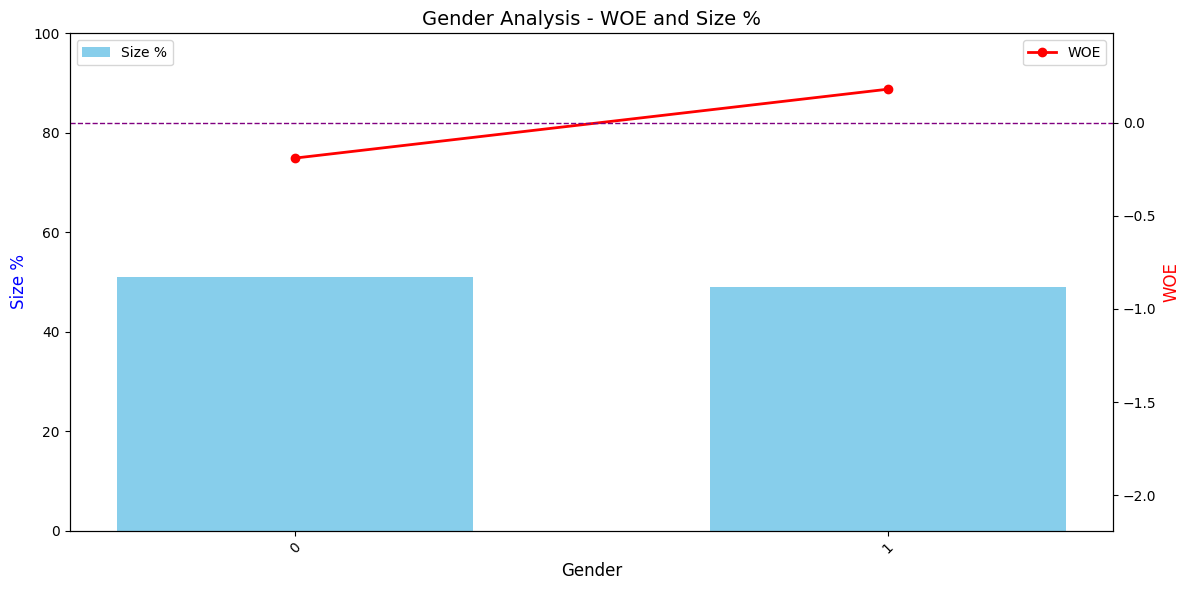

In [ ]:
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot with a primary axis for "Size %" and a secondary axis for "WOE"
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data[feature_column],
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('Gender', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
# Force x-axis ticks to be only 0 and 1
ax1.set_xticks([0, 1])
ax1.set_xticklabels([0, 1])
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data[feature_column],
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('Gender Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Target variable is ART_status and the updated feature
feature_column = 'New_TB_Case'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely (avoiding log(0))
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ["Total"],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    })

    # Reset index before concatenation
    grouped = grouped.reset_index()

    # Sort the grouped data by WOE in descending order
    grouped_sorted = grouped.sort_values(by='WOE', ascending=False)

    # Append the totals row to the sorted data
    grouped_sorted = pd.concat([grouped_sorted, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped_sorted = grouped_sorted[[feature, 'NotOnART', 'OnART', 'Total', 'Size %',
                                       '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped_sorted

# Ensure df is loaded before calling the function
# For example:
# df = pd.read_csv("your_data.csv")

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the sorted fine classing table with totals (e.g., in a Jupyter Notebook)
display("Sorted Fine Classing Table with Totals:")
display(fine_classing_table)

# Display the DataFrame with the mapped WOE values (preview)
display("DataFrame with WOE mapping:")
display(df.head())

'Sorted Fine Classing Table with Totals:'

,New_TB_Case,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,0,56,43,99,15.07,11.64,24.43,56.57,0.74
1,1,425,133,558,84.93,88.36,75.57,76.16,-0.16
2,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,COSH_PHC,Rx_Outcome,Rx_Outcome_2,Time_To_Move,Time_To_Link,Gender_WOE,New_TB_Case_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,1,3,2,36.0,7.0,-0.19,-0.16
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,2,2,1,15.0,2.0,-0.19,-0.16
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,1,2,1,36.0,7.0,0.18,-0.16
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,1,2,1,36.0,7.0,-0.19,-0.16
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,2,2,1,19.0,7.0,0.18,-0.16


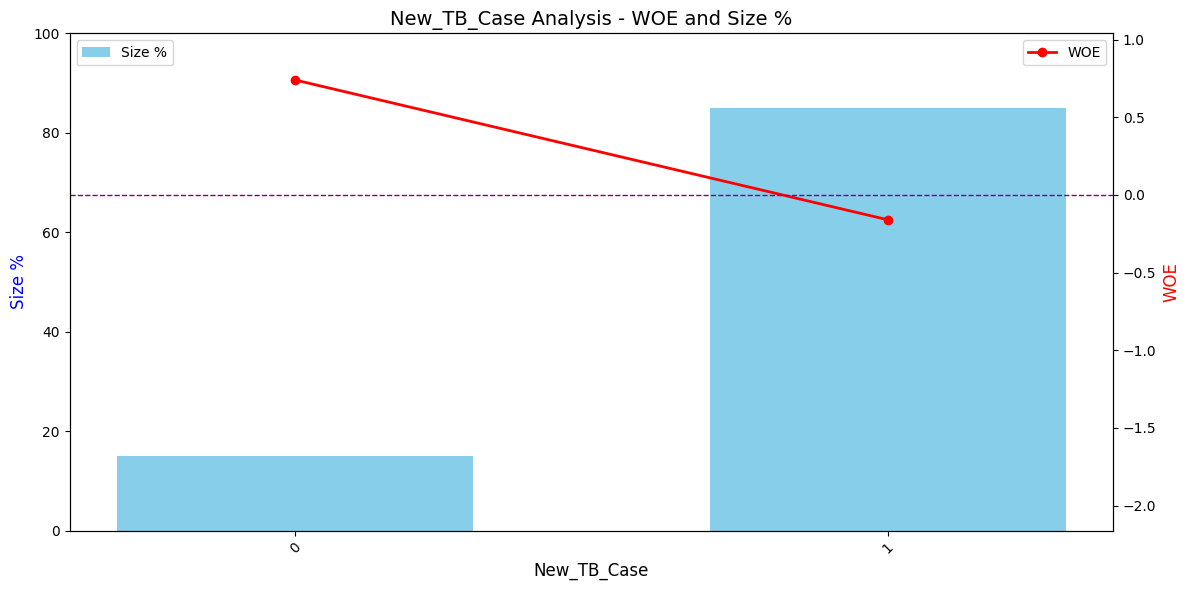

In [ ]:
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot with a primary axis for "Size %" and a secondary axis for "WOE"
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data[feature_column],
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('New_TB_Case', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
# Force x-axis ticks to be only 0 and 1
ax1.set_xticks([0, 1])
ax1.set_xticklabels([0, 1])
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data[feature_column],
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('New_TB_Case Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Target variable is ART_status
feature_column = 'Pulmonary_TB'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely (avoiding log(0))
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ["Total"],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    })

    # Reset index to ensure the feature appears as a column
    grouped = grouped.reset_index()

    # Sort the grouped data by WOE in descending order
    grouped_sorted = grouped.sort_values(by='WOE', ascending=False)

    # Append the totals row to the sorted data
    grouped_sorted = pd.concat([grouped_sorted, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped_sorted = grouped_sorted[[feature, 'NotOnART', 'OnART', 'Total', 'Size %',
                                       '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped_sorted

# Ensure df is loaded before calling the function
# For example:
# df = pd.read_csv("your_data.csv")

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the sorted fine classing table with totals (in Jupyter Notebook or IPython)
display("Sorted Fine Classing Table with Totals:")
display(fine_classing_table)

# Display the DataFrame with the mapped WOE values (preview)
display("DataFrame with WOE mapping:")
display(df.head())


'Sorted Fine Classing Table with Totals:'

,Pulmonary_TB,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,0.0,57,26,83,12.63,11.85,14.77,68.67,0.22
1,1.0,424,150,574,87.37,88.15,85.23,73.87,-0.03
2,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,COSH_PHC,Rx_Outcome,Rx_Outcome_2,Time_To_Move,Time_To_Link,Gender_WOE,New_TB_Case_WOE,Pulmonary_TB_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,1,3,2,36.0,7.0,-0.19,-0.16,-0.03
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,2,2,1,15.0,2.0,-0.19,-0.16,-0.03
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,1,2,1,36.0,7.0,0.18,-0.16,-0.03
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,1,2,1,36.0,7.0,-0.19,-0.16,-0.03
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,2,2,1,19.0,7.0,0.18,-0.16,-0.03


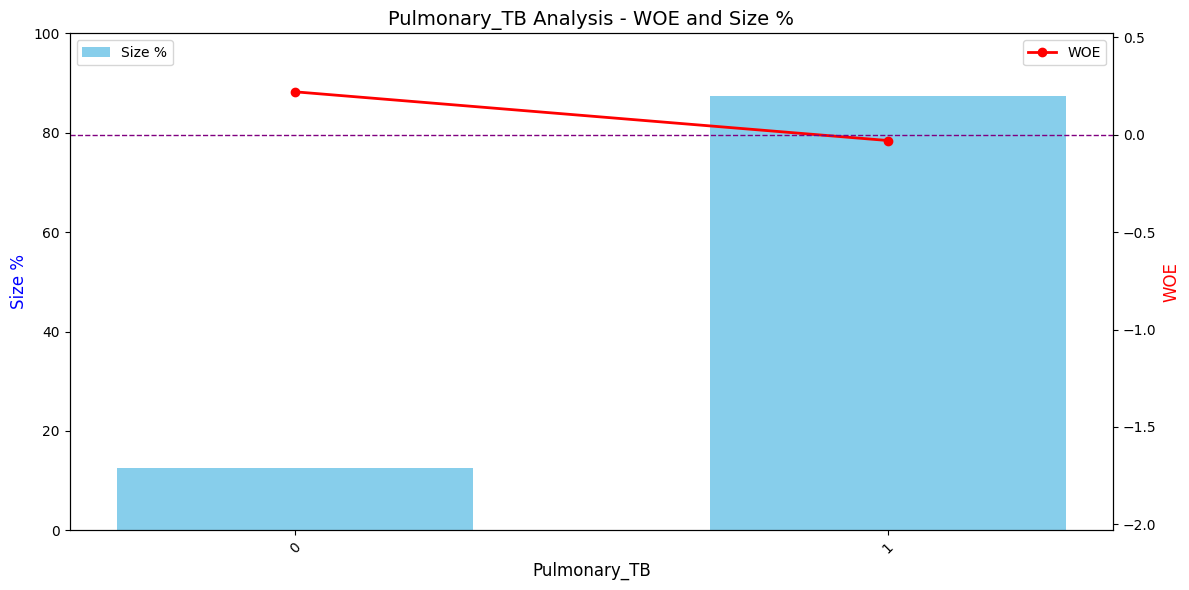

In [ ]:
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot with a primary axis for "Size %" and a secondary axis for "WOE"
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data[feature_column],
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('Pulmonary_TB', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
# Force x-axis ticks to be only 0 and 1
ax1.set_xticks([0, 1])
ax1.set_xticklabels([0, 1])
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data[feature_column],
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('Pulmonary_TB Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Target variable is ART_status and feature is AFB_Positive_Ever
feature_column = 'AFB_Positive_Ever'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely (avoiding log(0))
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    })

    # Reset index before sorting and appending totals row
    grouped = grouped.reset_index()

    # Sort the grouped data by WOE in descending order
    grouped_sorted = grouped.sort_values(by='WOE', ascending=False)

    # Append the totals row to the sorted data
    grouped_sorted = pd.concat([grouped_sorted, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped_sorted = grouped_sorted[[feature, 'NotOnART', 'OnART', 'Total', 'Size %',
                                       '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped_sorted

# Ensure df is loaded before calling the function
# For example, you might load your data using:
# df = pd.read_csv("your_data.csv")

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the sorted fine classing table with totals (e.g., in Jupyter Notebook or IPython)
display("Sorted Fine Classing Table with Totals:")
display(fine_classing_table)

# Display the DataFrame with the mapped WOE values (preview)
display("DataFrame with WOE mapping:")
display(df.head())

'Sorted Fine Classing Table with Totals:'

,AFB_Positive_Ever,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,0.0,448,167,615,93.61,93.14,94.89,72.85,0.02
1,1.0,33,9,42,6.39,6.86,5.11,78.57,-0.29
2,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,COSH_PHC,Rx_Outcome,Rx_Outcome_2,Time_To_Move,Time_To_Link,Gender_WOE,New_TB_Case_WOE,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,1,3,2,36.0,7.0,-0.19,-0.16,-0.03,0.02
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,2,2,1,15.0,2.0,-0.19,-0.16,-0.03,0.02
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,1,2,1,36.0,7.0,0.18,-0.16,-0.03,0.02
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,1,2,1,36.0,7.0,-0.19,-0.16,-0.03,0.02
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,2,2,1,19.0,7.0,0.18,-0.16,-0.03,0.02


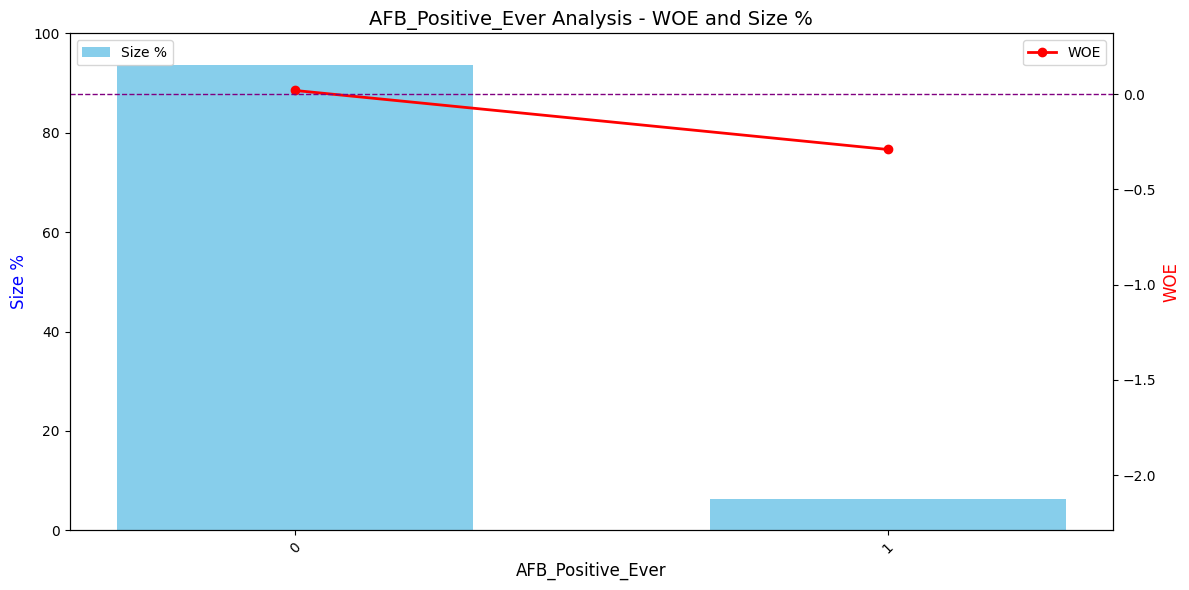

In [ ]:
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot with a primary axis for "Size %" and a secondary axis for "WOE"
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data[feature_column],
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('AFB_Positive_Ever', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
# Force x-axis ticks to be only 0 and 1
ax1.set_xticks([0, 1])
ax1.set_xticklabels([0, 1])
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data[feature_column],
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('AFB_Positive_Ever Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Target variable is ART_status and the feature is Culture_Positive_Ever
feature_column = 'Culture_Positive_Ever'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely (avoiding log(0))
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    })

    # Reset index so that the feature appears as a column
    grouped = grouped.reset_index()

    # Sort the grouped data by WOE in descending order
    grouped_sorted = grouped.sort_values(by='WOE', ascending=False)

    # Append the totals row to the sorted data
    grouped_sorted = pd.concat([grouped_sorted, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped_sorted = grouped_sorted[[feature, 'NotOnART', 'OnART', 'Total', 'Size %',
                                       '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped_sorted

# Ensure df is loaded before calling the function
# For example, if your data is in a CSV file:
# df = pd.read_csv("your_data.csv")

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the sorted fine classing table with totals
display("Sorted Fine Classing Table with Totals:")
display(fine_classing_table)

# Display the DataFrame with the mapped WOE values (preview)
display("DataFrame with WOE mapping:")
display(df.head())


'Sorted Fine Classing Table with Totals:'

,Culture_Positive_Ever,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,1.0,44,20,64,9.74,9.15,11.36,68.75,0.22
1,0.0,437,156,593,90.26,90.85,88.64,73.69,-0.02
2,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,COSH_PHC,Rx_Outcome,Rx_Outcome_2,Time_To_Move,Time_To_Link,Gender_WOE,New_TB_Case_WOE,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE,Culture_Positive_Ever_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,1,3,2,36.0,7.0,-0.19,-0.16,-0.03,0.02,-0.02
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,2,2,1,15.0,2.0,-0.19,-0.16,-0.03,0.02,-0.02
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,1,2,1,36.0,7.0,0.18,-0.16,-0.03,0.02,-0.02
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,1,2,1,36.0,7.0,-0.19,-0.16,-0.03,0.02,-0.02
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,2,2,1,19.0,7.0,0.18,-0.16,-0.03,0.02,-0.02


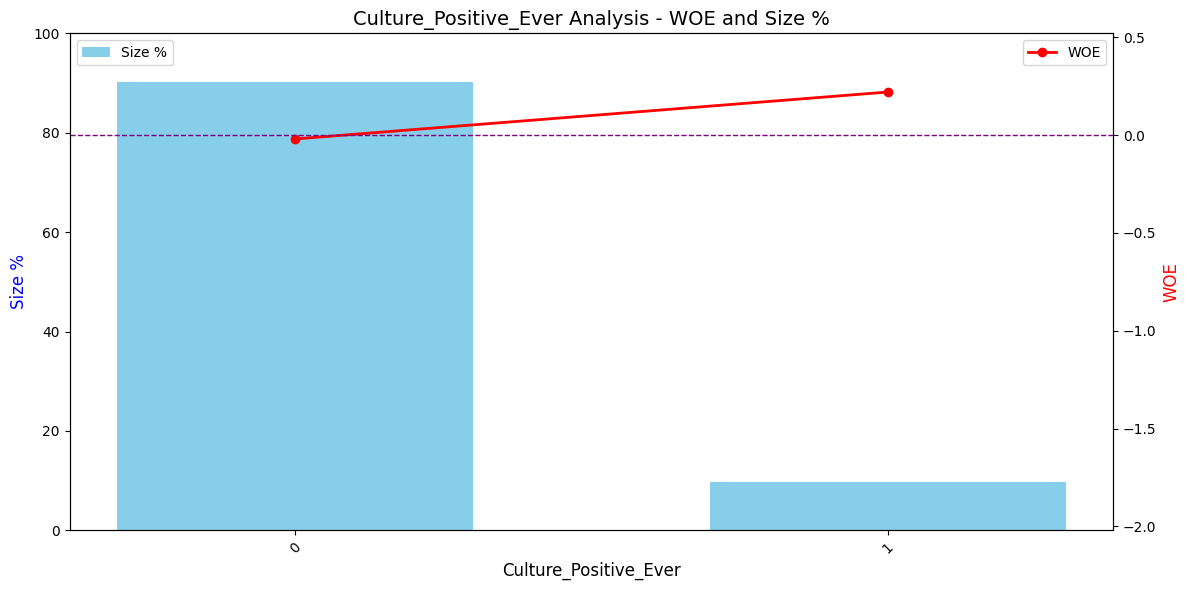

In [ ]:
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot with a primary axis for "Size %" and a secondary axis for "WOE"
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data[feature_column],
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('Culture_Positive_Ever', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
# Force x-axis ticks to be only 0 and 1
ax1.set_xticks([0, 1])
ax1.set_xticklabels([0, 1])
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data[feature_column],
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('Culture_Positive_Ever Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Target variable is ART_status and feature is Micro_Conf
feature_column = 'Micro_Conf'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely (avoiding log(0))
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    })

    # Reset index so that the feature appears as a column
    grouped = grouped.reset_index()

    # Sort the grouped data by WOE in descending order
    grouped_sorted = grouped.sort_values(by='WOE', ascending=False)

    # Append the totals row to the sorted data
    grouped_sorted = pd.concat([grouped_sorted, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped_sorted = grouped_sorted[[feature, 'NotOnART', 'OnART', 'Total', 'Size %',
                                       '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped_sorted

# Ensure df is loaded before calling the function
# For example:
# df = pd.read_csv("your_data.csv")

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the sorted fine classing table with totals (in Jupyter Notebook or IPython)
display("Sorted Fine Classing Table with Totals:")
display(fine_classing_table)

# Display the DataFrame with the mapped WOE values (preview)
display("DataFrame with WOE mapping:")
display(df.head())

'Sorted Fine Classing Table with Totals:'

,Micro_Conf,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,1,54,25,79,12.02,11.23,14.2,68.35,0.23
1,0,427,151,578,87.98,88.77,85.8,73.88,-0.03
2,Total,481,176,657,100.00,100.00,100.0,73.21,NaN


'DataFrame with WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,Rx_Outcome,Rx_Outcome_2,Time_To_Move,Time_To_Link,Gender_WOE,New_TB_Case_WOE,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE,Culture_Positive_Ever_WOE,Micro_Conf_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,3,2,36.0,7.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,2,1,15.0,2.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,2,1,36.0,7.0,0.18,-0.16,-0.03,0.02,-0.02,-0.03
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,2,1,36.0,7.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,2,1,19.0,7.0,0.18,-0.16,-0.03,0.02,-0.02,-0.03


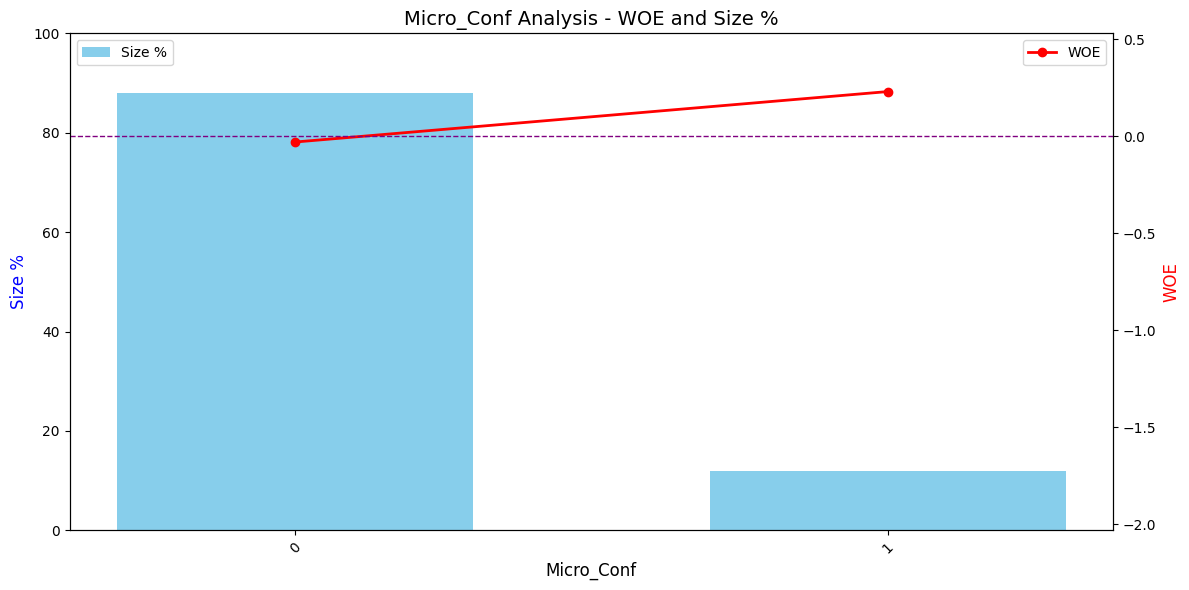

In [ ]:
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot with a primary axis for "Size %" and a secondary axis for "WOE"
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data[feature_column],
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('Micro_Conf', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
# Force x-axis ticks to be only 0 and 1
ax1.set_xticks([0, 1])
ax1.set_xticklabels([0, 1])
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data[feature_column],
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('Micro_Conf Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# Target variable is ART_status and the feature is Other_Basis_Dx
feature_column = 'Other_Basis_Dx'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Introduce a small epsilon to avoid division by zero in the WOE calculation
    epsilon = 1e-5
    grouped['WOE'] = np.log((grouped['%OnART'] + epsilon) / (grouped['%NotOnART'] + epsilon)).round(2)

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=['Total'])

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals])

    # Reorder columns for clarity
    grouped = grouped[['NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    # Set the index name explicitly and reset the index so the feature appears as a column
    grouped.index.name = feature
    grouped = grouped.reset_index()

    return df, grouped

# Ensure df is loaded before calling the function
# For example:
# df = pd.read_csv("your_data.csv")

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the resulting fine classing table with totals
display("Fine Classing Table with Totals:")
display(fine_classing_table)

# Optionally, display the DataFrame with the mapped WOE values
display("DataFrame with WOE mapping:")
display(df.head())

'Fine Classing Table with Totals:'

,Other_Basis_Dx,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,1.0,476,170,646,98.33,98.96,96.59,73.68,-0.02
1,2.0,4,3,7,1.07,0.83,1.70,57.14,0.72
2,3.0,1,2,3,0.46,0.21,1.14,33.33,1.69
3,4.0,0,1,1,0.15,0.00,0.57,0.00,10.95
4,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,Rx_Outcome_2,Time_To_Move,Time_To_Link,Gender_WOE,New_TB_Case_WOE,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE,Culture_Positive_Ever_WOE,Micro_Conf_WOE,Other_Basis_Dx_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,2,36.0,7.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,1,15.0,2.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,1,36.0,7.0,0.18,-0.16,-0.03,0.02,-0.02,-0.03,-0.02
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,1,36.0,7.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,1,19.0,7.0,0.18,-0.16,-0.03,0.02,-0.02,-0.03,-0.02


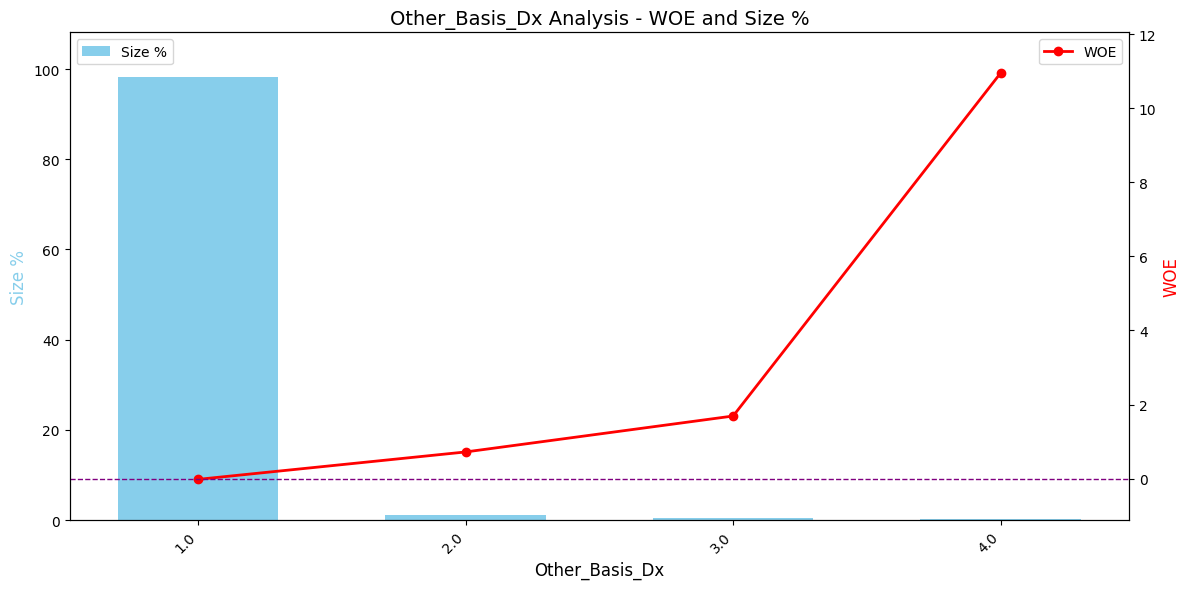

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Configuration
# =========================
feature_column = "Other_Basis_Dx"   # your feature column name
size_col = "Size %"
woe_col  = "WOE"

# =========================
# Prepare data
# =========================
plot_data = (
    fine_classing_table
      .loc[fine_classing_table[feature_column].astype(str).str.lower() != "total",
           [feature_column, size_col, woe_col]]
      .copy()
)

plot_data[size_col] = pd.to_numeric(plot_data[size_col], errors="coerce")
plot_data[woe_col]  = pd.to_numeric(plot_data[woe_col], errors="coerce")

# convert fraction to percentage if necessary
if plot_data[size_col].max() <= 1:
    plot_data[size_col] *= 100.0

# sort by WOE ascending → lowest to highest
plot_data = plot_data.sort_values(by=woe_col, ascending=True).reset_index(drop=True)

# =========================
# Plot
# =========================
x = np.arange(len(plot_data))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars: Size % (sky blue)
bars = ax1.bar(
    x,
    plot_data[size_col].values,
    color='skyblue',      # <---- sky blue color
    width=0.6,
    label="Size %"
)
ax1.set_xlabel(feature_column, fontsize=12)
ax1.set_ylabel("Size %", fontsize=12, color="skyblue")
ax1.set_ylim(0, max(100, plot_data[size_col].max() * 1.1))
ax1.set_xticks(x)
ax1.set_xticklabels(plot_data[feature_column].astype(str), rotation=45, ha="right")

# Line: WOE (red line + markers)
ax2 = ax1.twinx()
ax2.plot(
    x,
    plot_data[woe_col].values,
    color="red",
    marker="o",
    linewidth=2,
    label="WOE"
)
ax2.set_ylabel("WOE", fontsize=12, color="red")
ax2.axhline(0, linestyle="--", linewidth=1, color="purple")

# pad WOE y-limits
m, M = plot_data[woe_col].min(), plot_data[woe_col].max()
pad = max(0.3, 0.1 * (M - m if M > m else 1))
ax2.set_ylim(m - pad, M + pad)

# Title and legends
plt.title(f"{feature_column} Analysis - WOE and Size %", fontsize=14)
ax1.legend(loc="upper left", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# Target variable is ART_status and the feature is AFB_Positive_Ever
feature_column = 'AFB_Positive_Ever'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE)
    grouped['WOE'] = np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2)

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=['Total'])

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals])

    # Reorder columns for clarity
    grouped = grouped[['NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    # Set the index name explicitly and reset index so the feature appears as a column
    grouped.index.name = feature
    grouped = grouped.reset_index()

    return df, grouped

# Ensure df is loaded before calling the function
# For example, if your data is stored in a CSV file, you might load it with:
# df = pd.read_csv("your_data.csv")

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the resulting fine classing table with totals
display("Fine Classing Table with Totals:")
display(fine_classing_table)

# Optionally, display a preview of the DataFrame with the mapped WOE values
display("DataFrame with WOE mapping:")
display(df.head())

'Fine Classing Table with Totals:'

,AFB_Positive_Ever,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,0.0,448,167,615,93.61,93.14,94.89,72.85,0.02
1,1.0,33,9,42,6.39,6.86,5.11,78.57,-0.29
2,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,Rx_Outcome_2,Time_To_Move,Time_To_Link,Gender_WOE,New_TB_Case_WOE,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE,Culture_Positive_Ever_WOE,Micro_Conf_WOE,Other_Basis_Dx_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,2,36.0,7.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,1,15.0,2.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,1,36.0,7.0,0.18,-0.16,-0.03,0.02,-0.02,-0.03,-0.02
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,1,36.0,7.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,1,19.0,7.0,0.18,-0.16,-0.03,0.02,-0.02,-0.03,-0.02


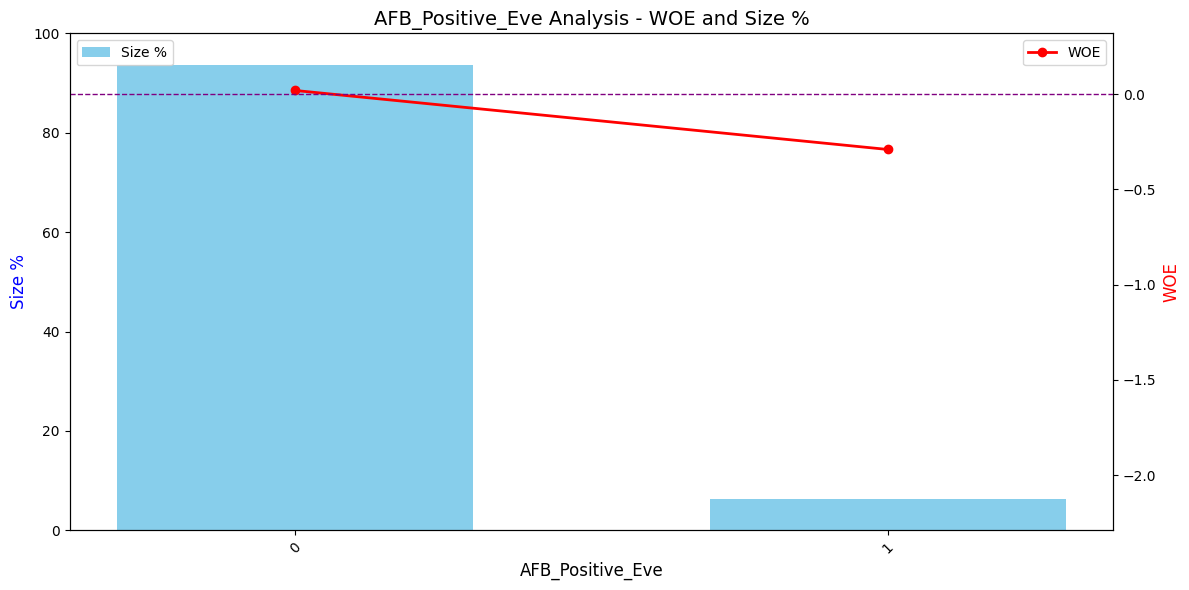

In [ ]:
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot with a primary axis for "Size %" and a secondary axis for "WOE"
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data[feature_column],
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('AFB_Positive_Eve', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
# Force x-axis ticks to be only 0 and 1
ax1.set_xticks([0, 1])
ax1.set_xticklabels([0, 1])
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data[feature_column],
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('AFB_Positive_Eve Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# ----- Step 1: Bin the Ages -----
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# ----- Step 2: Define the Fine Classing Function with Totals and WOE Mapping -----
def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the feature and compute count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category
    grouped['%NotOnART'] = (grouped['NotOnART'] / total_NotOnART * 100).round(2)
    grouped['%OnART'] = (grouped['OnART'] / total_OnART * 100).round(2)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Introduce a small epsilon to avoid division by zero in WOE calculation
    epsilon = 1e-5
    grouped['WOE'] = np.log((grouped['%OnART'] + epsilon) / (grouped['%NotOnART'] + epsilon)).round(2)

    # Map the calculated WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=['Total'])

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals])

    # Reorder columns for clarity
    grouped = grouped[['NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    # Set the index name to the feature and reset index so it appears as a column
    grouped.index.name = feature
    grouped = grouped.reset_index()

    return df, grouped

# ----- Step 3: Apply the Function and Display the Final Table -----
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature='age_group', target='ART_status')
display("Fine Classing Table with Totals:")
display(fine_classing_table)
display("DataFrame with WOE Mapping:")
display(df.head())


'Fine Classing Table with Totals:'

,age_group,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,<20,63,30,93,14.16,13.10,17.05,67.74,0.26
1,20-29,113,25,138,21.00,23.49,14.20,81.88,-0.50
2,30-39,150,71,221,33.64,31.19,40.34,67.87,0.26
3,40-49,97,38,135,20.55,20.17,21.59,71.85,0.07
4,50-59,40,10,50,7.61,8.32,5.68,80.00,-0.38
5,60-69,13,2,15,2.28,2.70,1.14,86.67,-0.86
6,70+,5,0,5,0.76,1.04,0.00,100.00,-11.55
7,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with WOE Mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,Time_To_Link,Gender_WOE,New_TB_Case_WOE,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE,Culture_Positive_Ever_WOE,Micro_Conf_WOE,Other_Basis_Dx_WOE,age_group,age_group_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,7.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,40-49,0.07
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,2.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,70+,-11.55
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,7.0,0.18,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,30-39,0.26
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,7.0,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,30-39,0.26
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,7.0,0.18,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,20-29,-0.50


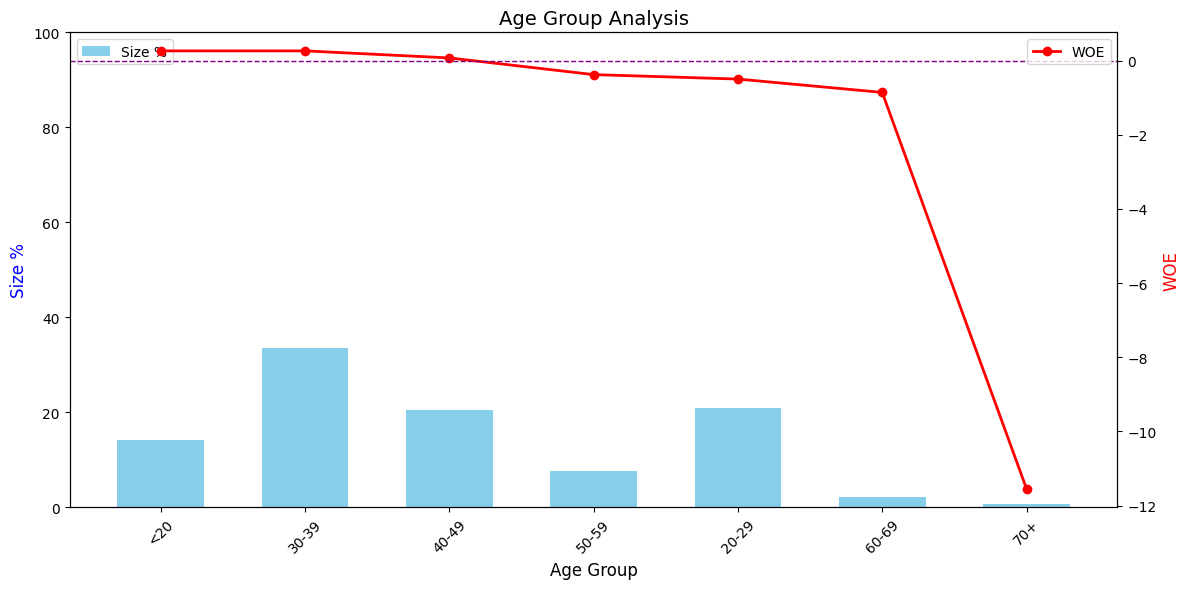

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reset index to access "Age" column
plot_data_age = fine_classing_table.reset_index()

# Remove the "Total" row
plot_data_age = plot_data_age[plot_data_age['age_group'] != 'Total']

# Sort based on WOE
plot_data_age = plot_data_age.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Get min and max WOE values safely
woe_min = plot_data_age['WOE'].min()
woe_max = plot_data_age['WOE'].max()

# Check for NaN or Inf values and set safe limits
if not np.isfinite(woe_min) or not np.isfinite(woe_max):
    woe_min, woe_max = -1, 1  # Default safe range

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data_age['age_group'],
    plot_data_age['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Age Group', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data_age['age_group'],
    plot_data_age['WOE'],
    color='red',
    marker='o',
    linestyle='-',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')

# Set safe limits for WOE axis
ax2.set_ylim(woe_min - 0.5, woe_max + 0.5)

# Add a horizontal reference line for WOE = 0
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add titles and legends
plt.title('Age Group Analysis', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# For these data, our target variable is ART_status.
# Feature is COSH_PHC
feature_column = 'COSH_PHC'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (assuming a binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_bad = grouped['NotOnART'].sum()
    total_good = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category
    grouped['%NotOnART'] = (grouped['NotOnART'] / total_bad * 100).round(2)
    grouped['%OnART'] = (grouped['OnART'] / total_good * 100).round(2)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE)
    grouped['WOE'] = np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2)

    # Map the computed WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_bad],
        'OnART': [total_good],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_bad / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=['Total'])

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals])

    # Reorder columns for clarity
    grouped = grouped[['NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    # Reset index and rename the index column to the feature name
    grouped = grouped.reset_index().rename(columns={'index': feature})

    return df, grouped

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the fine classing table
display("Fine Classing Table for COSH_PHC:")
display(fine_classing_table)

# Display a preview of the DataFrame with the mapped WOE values
display("DataFrame with COSH_PHC_WOE mapping:")
display(df.head())

'Fine Classing Table for COSH_PHC:'

,COSH_PHC,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,1,271,106,377,57.38,56.34,60.23,71.88,0.07
1,2,210,70,280,42.62,43.66,39.77,75.00,-0.09
2,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with COSH_PHC_WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,Gender_WOE,New_TB_Case_WOE,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE,Culture_Positive_Ever_WOE,Micro_Conf_WOE,Other_Basis_Dx_WOE,age_group,age_group_WOE,COSH_PHC_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,40-49,0.07,0.07
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,70+,-11.55,-0.09
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,0.18,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,30-39,0.26,0.07
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,-0.19,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,30-39,0.26,0.07
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,0.18,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,20-29,-0.50,-0.09


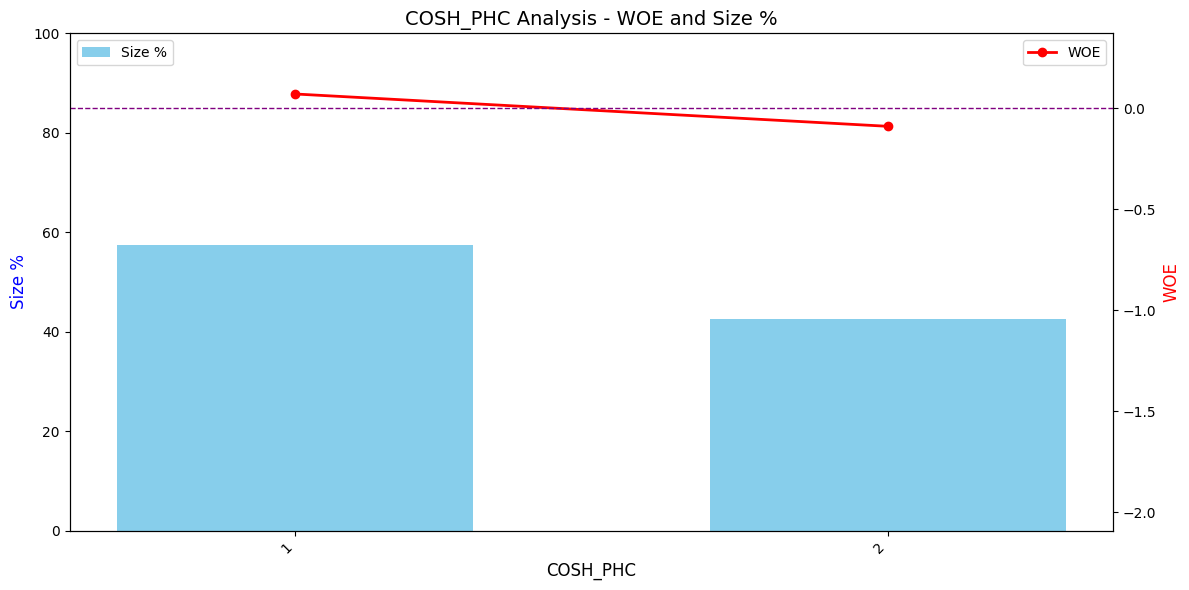

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# If your feature column is numeric, convert it to string so labels look better
plot_data[feature_column] = plot_data[feature_column].astype(str)

# Create a numeric array for x-axis positions
x_positions = np.arange(len(plot_data))

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Primary axis: Bar chart for "Size %" ----
ax1.bar(
    x_positions,
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('COSH_PHC', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)

# Set x-axis ticks & labels
ax1.set_xticks(x_positions)
ax1.set_xticklabels(plot_data[feature_column], rotation=45, ha='right')

# ---- Secondary axis: Plot for "WOE" ----
ax2 = ax1.twinx()
ax2.plot(
    x_positions,
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('COSH_PHC Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# For these data, our target variable is ART_status.
# Feature is Rx_Outcome_2
feature_column = 'Rx_Outcome'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (assuming a binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_bad = grouped['NotOnART'].sum()
    total_good = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category
    grouped['%NotOnART'] = (grouped['NotOnART'] / total_bad * 100).round(2)      # Percentage of NotOnART
    grouped['%OnART'] = (grouped['OnART'] / total_good * 100).round(2)            # Percentage of OnART
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)           # Group size percentage

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) with a continuity correction to avoid division by zero
    grouped['WOE'] = np.log(
        grouped['%OnART'].replace(0, 0.0001) / grouped['%NotOnART'].replace(0, 0.0001)
    ).round(2)

    # Map the computed WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_bad],
        'OnART': [total_good],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_bad / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=['Total'])

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals])

    # Reorder columns for clarity
    grouped = grouped[['NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    # Reset index and rename the index column to the feature name
    grouped = grouped.reset_index().rename(columns={'index': feature})

    return df, grouped

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the fine classing table
display("Fine Classing Table for Rx_Outcome:")
display(fine_classing_table)

# Optionally, display a preview of the DataFrame with the mapped WOE values
display("DataFrame with Rx_Outcome_2_WOE mapping:")
display(df.head())


'Fine Classing Table for Rx_Outcome:'

,Rx_Outcome,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,1,51,17,68,10.35,10.60,9.66,75.00,-0.09
1,2,337,135,472,71.84,70.06,76.70,71.40,0.09
2,3,53,16,69,10.50,11.02,9.09,76.81,-0.19
3,4,20,3,23,3.50,4.16,1.70,86.96,-0.89
4,5,19,4,23,3.50,3.95,2.27,82.61,-0.55
5,6,1,0,1,0.15,0.21,0.00,100.00,-7.65
6,7,0,1,1,0.15,0.00,0.57,0.00,8.65
7,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with Rx_Outcome_2_WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,New_TB_Case_WOE,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE,Culture_Positive_Ever_WOE,Micro_Conf_WOE,Other_Basis_Dx_WOE,age_group,age_group_WOE,COSH_PHC_WOE,Rx_Outcome_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,40-49,0.07,0.07,-0.19
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,70+,-11.55,-0.09,0.09
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,30-39,0.26,0.07,0.09
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,30-39,0.26,0.07,0.09
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,-0.16,-0.03,0.02,-0.02,-0.03,-0.02,20-29,-0.50,-0.09,0.09


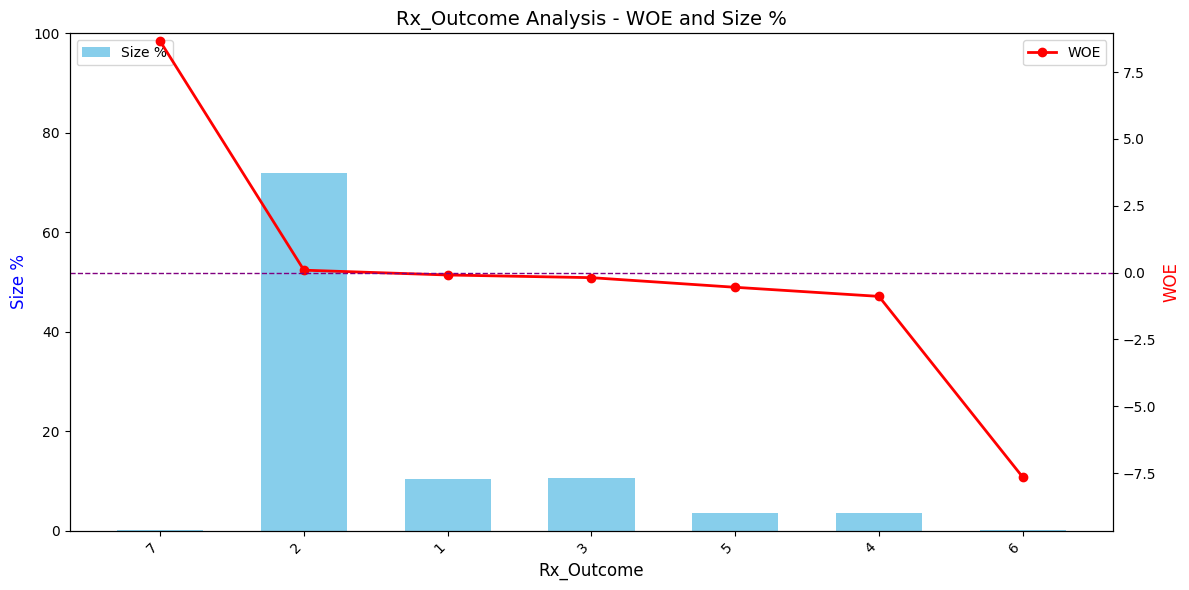

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# If your feature column is numeric, convert it to string so labels look better
plot_data[feature_column] = plot_data[feature_column].astype(str)

# Create a numeric array for x-axis positions
x_positions = np.arange(len(plot_data))

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Primary axis: Bar chart for "Size %" ----
ax1.bar(
    x_positions,
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('Rx_Outcome', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)

# Set x-axis ticks & labels
ax1.set_xticks(x_positions)
ax1.set_xticklabels(plot_data[feature_column], rotation=45, ha='right')

# ---- Secondary axis: Plot for "WOE" ----
ax2 = ax1.twinx()
ax2.plot(
    x_positions,
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('Rx_Outcome Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# For these data, our target variable is ART_status.
# Feature is Rx_Outcome_2
feature_column = 'Rx_Outcome_2'

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (assuming a binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_bad = grouped['NotOnART'].sum()
    total_good = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category
    grouped['%NotOnART'] = (grouped['NotOnART'] / total_bad * 100).round(2)      # Percentage of NotOnART
    grouped['%OnART'] = (grouped['OnART'] / total_good * 100).round(2)            # Percentage of OnART
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)           # Group size percentage

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) with a continuity correction to avoid division by zero
    grouped['WOE'] = np.log(
        grouped['%OnART'].replace(0, 0.0001) / grouped['%NotOnART'].replace(0, 0.0001)
    ).round(2)

    # Map the computed WOE values back to the original DataFrame as a new column
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_bad],
        'OnART': [total_good],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_bad / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=['Total'])

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals])

    # Reorder columns for clarity
    grouped = grouped[['NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    # Reset index and rename the index column to the feature name
    grouped = grouped.reset_index().rename(columns={'index': feature})

    return df, grouped

# Apply the function to the dataset for the chosen feature using ART_status as the target
df, fine_classing_table = fine_classing_with_totals_and_mapping(df, feature=feature_column, target='ART_status')

# Display the fine classing table
display("Fine Classing Table for Rx_Outcome_2:")
display(fine_classing_table)

# Optionally, display a preview of the DataFrame with the mapped WOE values
display("DataFrame with Rx_Outcome_2_WOE mapping:")
display(df.head())


'Fine Classing Table for Rx_Outcome_2:'

,Rx_Outcome_2,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,1,388,152,540,82.19,80.67,86.36,71.85,0.07
1,2,53,16,69,10.50,11.02,9.09,76.81,-0.19
2,3,39,7,46,7.00,8.11,3.98,84.78,-0.71
3,4,1,0,1,0.15,0.21,0.00,100.00,-7.65
4,5,0,1,1,0.15,0.00,0.57,0.00,8.65
5,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with Rx_Outcome_2_WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,Pulmonary_TB_WOE,AFB_Positive_Ever_WOE,Culture_Positive_Ever_WOE,Micro_Conf_WOE,Other_Basis_Dx_WOE,age_group,age_group_WOE,COSH_PHC_WOE,Rx_Outcome_WOE,Rx_Outcome_2_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,-0.03,0.02,-0.02,-0.03,-0.02,40-49,0.07,0.07,-0.19,-0.19
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,-0.03,0.02,-0.02,-0.03,-0.02,70+,-11.55,-0.09,0.09,0.07
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,-0.03,0.02,-0.02,-0.03,-0.02,30-39,0.26,0.07,0.09,0.07
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,-0.03,0.02,-0.02,-0.03,-0.02,30-39,0.26,0.07,0.09,0.07
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,-0.03,0.02,-0.02,-0.03,-0.02,20-29,-0.50,-0.09,0.09,0.07


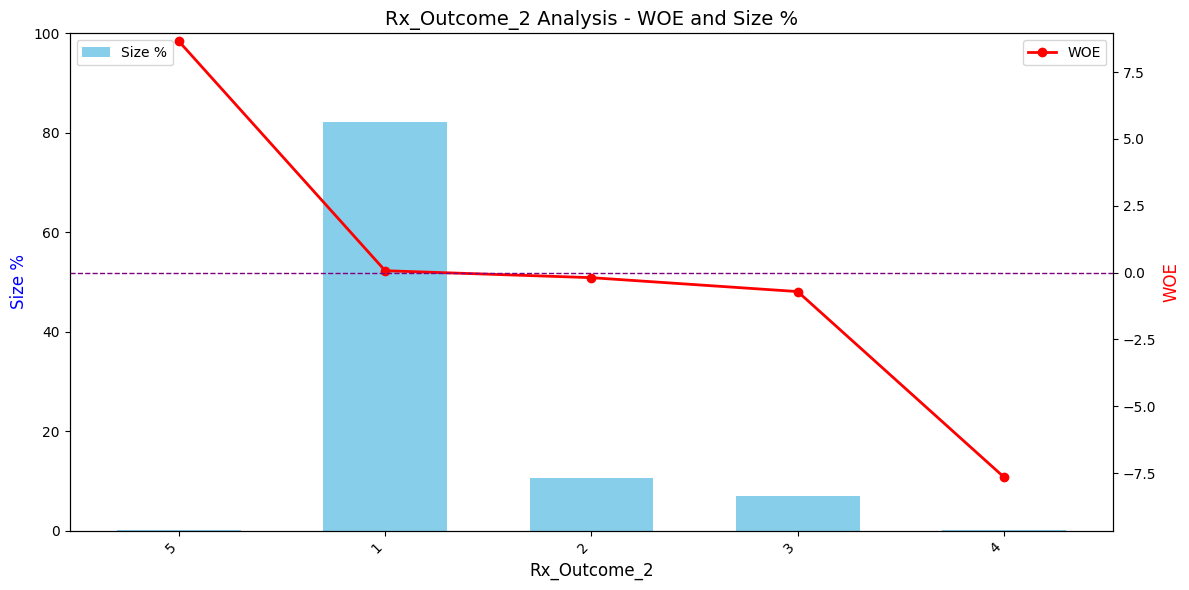

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Remove the "Total" row and sort by WOE in descending order
plot_data = fine_classing_table[fine_classing_table[feature_column] != 'Total']
plot_data = plot_data.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# If your feature column is numeric, convert it to string so labels look better
plot_data[feature_column] = plot_data[feature_column].astype(str)

# Create a numeric array for x-axis positions
x_positions = np.arange(len(plot_data))

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Primary axis: Bar chart for "Size %" ----
ax1.bar(
    x_positions,
    plot_data['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_xlabel('Rx_Outcome_2', fontsize=12)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)

# Set x-axis ticks & labels
ax1.set_xticks(x_positions)
ax1.set_xticklabels(plot_data[feature_column], rotation=45, ha='right')

# ---- Secondary axis: Plot for "WOE" ----
ax2 = ax1.twinx()
ax2.plot(
    x_positions,
    plot_data['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(plot_data['WOE'].min() - 2.0, plot_data['WOE'].max() + 0.3)
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add title and legends
plt.title('Rx_Outcome_2 Analysis - WOE and Size %', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load dataset (Ensure df is already loaded in your environment)
# df = pd.read_csv("your_data.csv")  # Uncomment if loading from a file

# Define CD4 bins and labels
cd4_bins = [-1, 50, 200, 350, 500, float("inf")]
cd4_labels = ["≤50", "51-200", "201-350", "351-500", ">500"]

# Create a new column with the CD4 categories
df["CD4_Band"] = pd.cut(df["CD4"], bins=cd4_bins, labels=cd4_labels)

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate the count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_bad = grouped['NotOnART'].sum()
    total_good = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_bad > 0, (grouped['NotOnART'] / total_bad * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_good > 0, (grouped['OnART'] / total_good * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely with a continuity correction to avoid division by zero
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame in a new column named 'CD4_WOE'
    woe_mapping = grouped['WOE'].to_dict()
    df["CD4_WOE"] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ["Total"],
        'NotOnART': [total_bad],
        'OnART': [total_good],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_bad / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=["Total"])

    # Reset index before concatenation
    grouped = grouped.reset_index()

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped = grouped[[feature, 'NotOnART', 'OnART', 'Total', 'Size %',
                        '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped

# Apply the function to the dataset for CD4_Band using ART_status as the target
df, fine_classing_table_cd4 = fine_classing_with_totals_and_mapping(df, feature="CD4_Band", target="ART_status")

# Display the fine classing table with totals
display("Fine Classing Table for CD4_Band:")
display(fine_classing_table_cd4)

# Optionally, display a preview of the DataFrame with the mapped WOE values
display("DataFrame with CD4_WOE mapping:")
display(df.head())

'Fine Classing Table for CD4_Band:'

,CD4_Band,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,≤50,127,30,157,23.90,26.40,17.05,80.89,-0.44
1,51-200,202,63,265,40.33,42.00,35.80,76.23,-0.16
2,201-350,93,44,137,20.85,19.33,25.00,67.88,0.26
3,351-500,20,16,36,5.48,4.16,9.09,55.56,0.78
4,>500,39,23,62,9.44,8.11,13.07,62.90,0.48
5,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with CD4_WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,Culture_Positive_Ever_WOE,Micro_Conf_WOE,Other_Basis_Dx_WOE,age_group,age_group_WOE,COSH_PHC_WOE,Rx_Outcome_WOE,Rx_Outcome_2_WOE,CD4_Band,CD4_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,-0.02,-0.03,-0.02,40-49,0.07,0.07,-0.19,-0.19,≤50,-0.44
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,-0.02,-0.03,-0.02,70+,-11.55,-0.09,0.09,0.07,≤50,-0.44
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,-0.02,-0.03,-0.02,30-39,0.26,0.07,0.09,0.07,51-200,-0.16
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,-0.02,-0.03,-0.02,30-39,0.26,0.07,0.09,0.07,51-200,-0.16
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,-0.02,-0.03,-0.02,20-29,-0.50,-0.09,0.09,0.07,51-200,-0.16


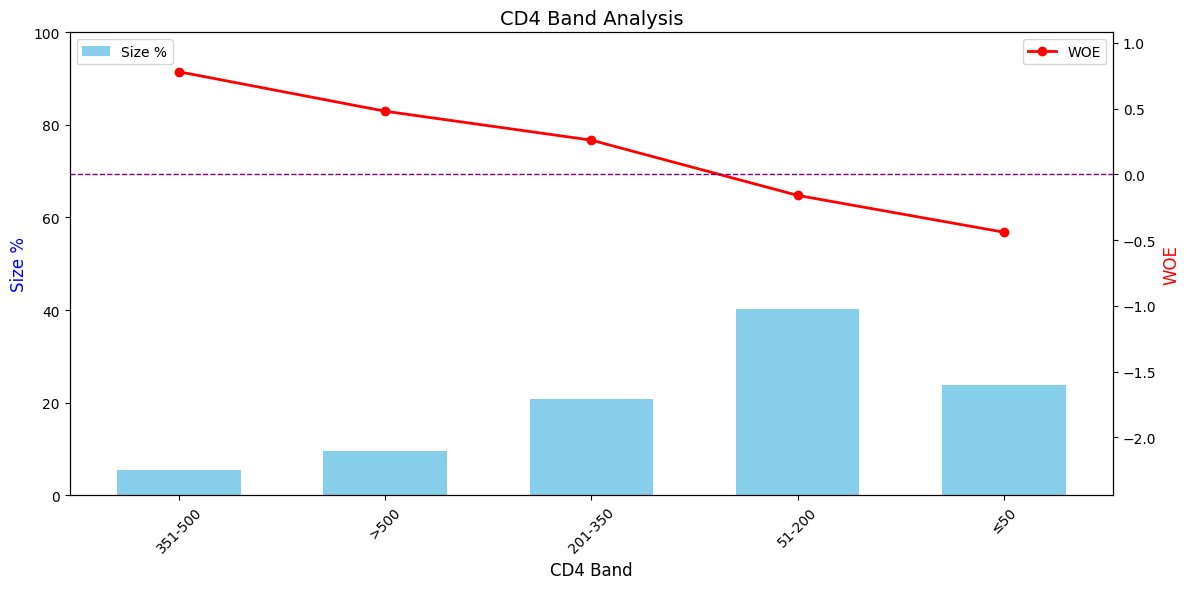

In [ ]:
import matplotlib.pyplot as plt

# Remove the "Total" row for plotting and sort by WOE in descending order
plot_data_cd4 = fine_classing_table_cd4[fine_classing_table_cd4['CD4_Band'] != 'Total']
plot_data_cd4 = plot_data_cd4.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data_cd4['CD4_Band'],
    plot_data_cd4['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
ax1.set_xlabel('CD4 Band', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data_cd4['CD4_Band'],
    plot_data_cd4['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(
    plot_data_cd4['WOE'].min() - 2.0,
    plot_data_cd4['WOE'].max() + 0.3
)

# Add a horizontal reference line for WOE = 0
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add titles and legends
plt.title('CD4 Band Analysis', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load dataset (ensure df is already loaded in your environment)
# df = pd.read_csv("your_data.csv")  # Uncomment if loading from a file

# Define bins and labels for Time_To_Move
time_to_move_bins = [-1, 7, 14, 30, 60, float("inf")]
time_to_move_labels = ["≤7 days", "8-14 days", "15-30 days", "31-60 days", ">60 days"]

# Create a new column with binned categories
df["Time_To_Move_Band"] = pd.cut(df["Time_To_Move"], bins=time_to_move_bins, labels=time_to_move_labels)

def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely with a continuity correction to avoid division by zero
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame in a new column named 'Time_To_Move_Band_WOE'
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)  # Using a different column name if needed
    # Alternatively, if you prefer: df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ["Total"],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=["Total"])

    # Reset index before concatenation
    grouped = grouped.reset_index()

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped = grouped[[feature, 'NotOnART', 'OnART', 'Total', 'Size %',
                        '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped

# Apply the function to the dataset for Time_To_Move_Band using ART_status as the target
df, fine_classing_table_time_move = fine_classing_with_totals_and_mapping(df, feature="Time_To_Move_Band", target="ART_status")

# Display the fine classing table with totals
display("Fine Classing Table for Time_To_Move_Band:")
display(fine_classing_table_time_move)

# Optionally, display a preview of the DataFrame with the mapped WOE values
display("DataFrame with Time_To_Move_Band_WOE mapping:")
display(df.head())

'Fine Classing Table for Time_To_Move_Band:'

,Time_To_Move_Band,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,≤7 days,76,25,101,15.37,15.80,14.20,75.25,-0.11
1,8-14 days,5,5,10,1.52,1.04,2.84,50.00,1.00
2,15-30 days,14,8,22,3.35,2.91,4.55,63.64,0.45
3,31-60 days,303,115,418,63.62,62.99,65.34,72.49,0.04
4,>60 days,83,23,106,16.13,17.26,13.07,78.30,-0.28
5,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with Time_To_Move_Band_WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,Other_Basis_Dx_WOE,age_group,age_group_WOE,COSH_PHC_WOE,Rx_Outcome_WOE,Rx_Outcome_2_WOE,CD4_Band,CD4_WOE,Time_To_Move_Band,Time_To_Move_Band_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,-0.02,40-49,0.07,0.07,-0.19,-0.19,≤50,-0.44,31-60 days,0.04
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,-0.02,70+,-11.55,-0.09,0.09,0.07,≤50,-0.44,15-30 days,0.45
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,-0.02,30-39,0.26,0.07,0.09,0.07,51-200,-0.16,31-60 days,0.04
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,-0.02,30-39,0.26,0.07,0.09,0.07,51-200,-0.16,31-60 days,0.04
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,-0.02,20-29,-0.50,-0.09,0.09,0.07,51-200,-0.16,15-30 days,0.45


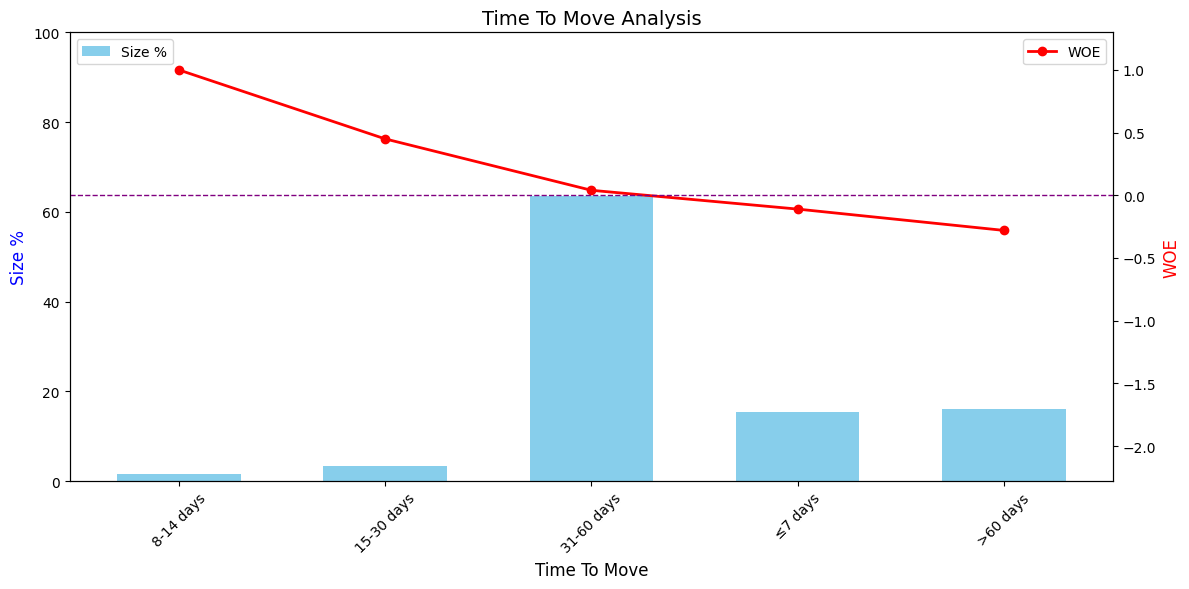

In [ ]:
# Remove the "Total" row for plotting and sort by WOE in descending order
plot_data_time_move = fine_classing_table_time_move[fine_classing_table_time_move['Time_To_Move_Band'] != 'Total']
plot_data_time_move = plot_data_time_move.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data_time_move['Time_To_Move_Band'],
    plot_data_time_move['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Time To Move', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data_time_move['Time_To_Move_Band'],
    plot_data_time_move['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(
    plot_data_time_move['WOE'].min() - 2.0,
    plot_data_time_move['WOE'].max() + 0.3
)

# Add a horizontal reference line for WOE = 0
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add titles and legends
plt.title('Time To Move Analysis', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

time_to_link_bins = [float("-inf"), 7, 14, 30, 60, float("inf")]
time_to_link_labels = ["≤7 days", "8-14 days", "15-30 days", "31-60 days", ">60 days"]

df["Time_To_Link_Band"] = pd.cut(df["Time_To_Link"], bins=time_to_link_bins, labels=time_to_link_labels)


def fine_classing_with_totals_and_mapping(df, feature, target):
    # Group by the specified feature and calculate count and sum (binary target)
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)

    # Calculate 'NotOnART' as the complement of 'OnART'
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    # Compute overall totals
    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    # Calculate percentages for each category (avoiding division by zero)
    grouped['%NotOnART'] = np.where(total_NotOnART > 0,
                                    (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART'] = np.where(total_OnART > 0,
                                 (grouped['OnART'] / total_OnART * 100).round(2), 0)
    grouped['Size %'] = (grouped['Total'] / total_count * 100).round(2)

    # Calculate the NotOnART Rate for each category
    grouped['NotOnART Rate'] = (grouped['NotOnART'] / grouped['Total'] * 100).round(2)

    # Compute Weight of Evidence (WOE) safely with a continuity correction to avoid division by zero
    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map the calculated WOE values back to the original DataFrame in a new column named 'Time_To_Move_Band_WOE'
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)  # Using a different column name if needed
    # Alternatively, if you prefer: df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Create a totals row summarizing the entire dataset
    totals = pd.DataFrame({
        feature: ["Total"],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2)],
        'WOE': [np.nan]
    }, index=["Total"])

    # Reset index before concatenation
    grouped = grouped.reset_index()

    # Append the totals row to the grouped data
    grouped = pd.concat([grouped, totals], ignore_index=True)

    # Reorder columns for clarity
    grouped = grouped[[feature, 'NotOnART', 'OnART', 'Total', 'Size %',
                        '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]

    return df, grouped

# Apply the function to the dataset for Time_To_Move_Band using ART_status as the target
df, fine_classing_table_time_link = fine_classing_with_totals_and_mapping(df, feature="Time_To_Link_Band", target="ART_status")

# Display the fine classing table with totals
display("Fine Classing Table for Time_To_Link_Band:")
display(fine_classing_table_time_link)

# Optionally, display a preview of the DataFrame with the mapped WOE values
display("DataFrame with Time_To_Link_Band_WOE mapping:")
display(df.head())


'Fine Classing Table for Time_To_Link_Band:'

,Time_To_Link_Band,NotOnART,OnART,Total,Size %,%NotOnART,%OnART,NotOnART Rate,WOE
0,≤7 days,411,150,561,85.39,85.45,85.23,73.26,-0.00
1,8-14 days,28,10,38,5.78,5.82,5.68,73.68,-0.02
2,15-30 days,24,10,34,5.18,4.99,5.68,70.59,0.13
3,31-60 days,14,4,18,2.74,2.91,2.27,77.78,-0.25
4,>60 days,4,2,6,0.91,0.83,1.14,66.67,0.32
5,Total,481,176,657,100.00,100.00,100.00,73.21,NaN


'DataFrame with Time_To_Link_Band_WOE mapping:'

,Age,Gender,New_TB_Case,Pulmonary_TB,AFB_Positive_Ever,Culture_Positive_Ever,Micro_Conf,Other_Basis_Dx,CD4,ART_status,...,age_group_WOE,COSH_PHC_WOE,Rx_Outcome_WOE,Rx_Outcome_2_WOE,CD4_Band,CD4_WOE,Time_To_Move_Band,Time_To_Move_Band_WOE,Time_To_Link_Band,Time_To_Link_Band_WOE
0,42.0,0,1,1.0,0.0,0.0,0,1.0,33.0,1,...,0.07,0.07,-0.19,-0.19,≤50,-0.44,31-60 days,0.04,≤7 days,-0.0
1,80.0,0,1,1.0,0.0,0.0,0,1.0,0.0,0,...,-11.55,-0.09,0.09,0.07,≤50,-0.44,15-30 days,0.45,≤7 days,-0.0
2,38.0,1,1,1.0,0.0,0.0,0,1.0,119.0,1,...,0.26,0.07,0.09,0.07,51-200,-0.16,31-60 days,0.04,≤7 days,-0.0
3,37.0,0,1,1.0,0.0,0.0,0,1.0,126.0,1,...,0.26,0.07,0.09,0.07,51-200,-0.16,31-60 days,0.04,≤7 days,-0.0
4,26.0,1,1,1.0,0.0,0.0,0,1.0,91.0,0,...,-0.50,-0.09,0.09,0.07,51-200,-0.16,15-30 days,0.45,≤7 days,-0.0


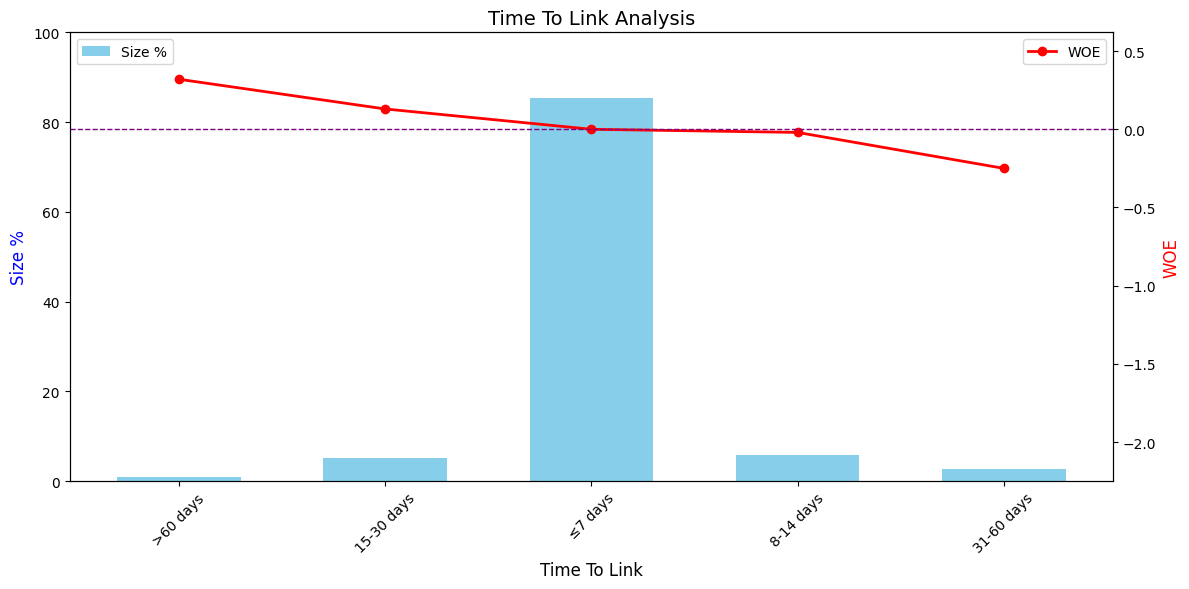

In [ ]:
# Remove the "Total" row for plotting and sort by WOE in descending order
plot_data_time_link = fine_classing_table_time_link[fine_classing_table_time_link['Time_To_Link_Band'] != 'Total']
plot_data_time_link = plot_data_time_link.sort_values(by='WOE', ascending=False).reset_index(drop=True)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for "Size %"
ax1.bar(
    plot_data_time_link['Time_To_Link_Band'],
    plot_data_time_link['Size %'],
    color='skyblue',
    label='Size %',
    width=0.6
)
ax1.set_ylabel('Size %', fontsize=12, color='blue')
ax1.set_ylim(0, 100)
ax1.set_xlabel('Time To Link', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Secondary y-axis for "WOE"
ax2 = ax1.twinx()
ax2.plot(
    plot_data_time_link['Time_To_Link_Band'],
    plot_data_time_link['WOE'],
    color='red',
    marker='o',
    label='WOE',
    linewidth=2
)
ax2.set_ylabel('WOE', fontsize=12, color='red')
ax2.set_ylim(
    plot_data_time_link['WOE'].min() - 2.0,
    plot_data_time_link['WOE'].max() + 0.3
)

# Add a horizontal reference line for WOE = 0
ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1)

# Add titles and legends
plt.title('Time To Link Analysis', fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================
# High-res + global font sizing
# =============================
plt.rcParams.update({
    "figure.dpi": 200,        # on-screen clarity
    "savefig.dpi": 600,       # exported file resolution
    "font.size": 14,          # base font size
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 14
})

# -----------------------------
# Special WOE logic (epsilon)
# -----------------------------
def epsilon_woe_classing(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    grouped['%NotOnART'] = np.where(total_NotOnART > 0, (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART']    = np.where(total_OnART > 0, (grouped['OnART']    / total_OnART    * 100).round(2), 0)
    grouped['Size %']    = (grouped['Total'] / total_count * 100).round(2)
    grouped['NotOnART Rate'] = np.where(grouped['Total'] > 0, (grouped['NotOnART'] / grouped['Total'] * 100).round(2), 0)

    epsilon = 1e-5
    grouped['WOE'] = np.log((grouped['%OnART'] + epsilon) / (grouped['%NotOnART'] + epsilon)).round(2)

    # Map WOE back to df
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Totals row
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2) if total_count > 0 else 0.0],
        'WOE': [np.nan]
    })

    grouped = grouped.reset_index()
    grouped_sorted = grouped.sort_values(by='WOE', ascending=False)
    grouped_sorted = pd.concat([grouped_sorted, totals], ignore_index=True)
    grouped_sorted = grouped_sorted[[feature, 'NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]
    return df, grouped_sorted

# -----------------------------
# Standard WOE logic
# -----------------------------
def standard_woe_classing(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'Total', 'sum': 'OnART'}, inplace=True)
    grouped['NotOnART'] = grouped['Total'] - grouped['OnART']

    total_NotOnART = grouped['NotOnART'].sum()
    total_OnART = grouped['OnART'].sum()
    total_count = grouped['Total'].sum()

    grouped['%NotOnART'] = np.where(total_NotOnART > 0, (grouped['NotOnART'] / total_NotOnART * 100).round(2), 0)
    grouped['%OnART']    = np.where(total_OnART > 0, (grouped['OnART']    / total_OnART    * 100).round(2), 0)
    grouped['Size %']    = (grouped['Total'] / total_count * 100).round(2)
    grouped['NotOnART Rate'] = np.where(grouped['Total'] > 0, (grouped['NotOnART'] / grouped['Total'] * 100).round(2), 0)

    grouped['WOE'] = np.where(
        (grouped['%OnART'] > 0) & (grouped['%NotOnART'] > 0),
        np.log(grouped['%OnART'] / grouped['%NotOnART']).round(2),
        np.nan
    )

    # Map WOE back to df
    woe_mapping = grouped['WOE'].to_dict()
    df[f'{feature}_WOE'] = df[feature].map(woe_mapping)

    # Totals row
    totals = pd.DataFrame({
        feature: ['Total'],
        'NotOnART': [total_NotOnART],
        'OnART': [total_OnART],
        'Total': [total_count],
        'Size %': [100.0],
        '%NotOnART': [100.0],
        '%OnART': [100.0],
        'NotOnART Rate': [(total_NotOnART / total_count * 100).round(2) if total_count > 0 else 0.0],
        'WOE': [np.nan]
    })

    grouped = grouped.reset_index()
    grouped_sorted = grouped.sort_values(by='WOE', ascending=False)
    grouped_sorted = pd.concat([grouped_sorted, totals], ignore_index=True)
    grouped_sorted = grouped_sorted[[feature, 'NotOnART', 'OnART', 'Total', 'Size %', '%NotOnART', '%OnART', 'NotOnART Rate', 'WOE']]
    return df, grouped_sorted

# -----------------------------
# Features
# -----------------------------
features = [
    'Gender', 'New_TB_Case', 'Pulmonary_TB', 'AFB_Positive_Ever',
    'age_group', 'COSH_PHC', 'Rx_Outcome', 'Rx_Outcome_2',
    'CD4_Band', 'Time_To_Move_Band', 'Time_To_Link_Band', 'Culture_Positive_Ever',
    'Micro_Conf', 'Other_Basis_Dx'
]
special_features = {'Rx_Outcome', 'Rx_Outcome_2', 'Other_Basis_Dx', 'age_group'}

# ------------------------------------------
# Build plot data (ASC only for Other_Basis_Dx)
# ------------------------------------------
plot_data_list = []
for feature in features:
    if feature in special_features:
        df, table = epsilon_woe_classing(df, feature, 'ART_status')
    else:
        df, table = standard_woe_classing(df, feature, 'ART_status')

    # Sort ascending by WOE only for Other_Basis_Dx; otherwise descending by WOE
    asc = (feature == 'Other_Basis_Dx')
    plot_data = (
        table[table[feature] != 'Total']
        .copy()
        .sort_values(by='WOE', ascending=asc, na_position='last')
        .reset_index(drop=True)
    )
    plot_data[feature] = plot_data[feature].astype(str)
    plot_data_list.append((feature, plot_data))

# -----------------------------
# Plot grid: 7 x 2 panels (bigger + clearer)
# -----------------------------
fig, axes = plt.subplots(7, 2, figsize=(32, 46), constrained_layout=True)
axes = axes.flatten()

for idx, (feature, plot_data) in enumerate(plot_data_list):
    ax = axes[idx]
    x = np.arange(len(plot_data))

    # Bars: Size %
    ax.bar(x, plot_data['Size %'], color='skyblue', label='Size %', width=0.6)
    ax.set_xlabel(feature, fontsize=18)
    ax.set_ylabel('Size %', fontsize=18, color='blue')
    ax.set_ylim(0, 100)
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data[feature], rotation=40, ha='right', fontsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.grid(axis='y', linestyle=':', alpha=0.5)

    # Line: WOE
    ax2 = ax.twinx()
    ax2.plot(
        x, plot_data['WOE'],
        color='red', marker='o', linewidth=2.8, markersize=6, label='WOE'
    )
    ax2.set_ylabel('WOE', fontsize=18, color='red')
    woe_min = plot_data['WOE'].min(skipna=True)
    woe_max = plot_data['WOE'].max(skipna=True)
    if not np.isfinite(woe_min) or not np.isfinite(woe_max):
        woe_min, woe_max = -1, 1
    ax2.set_ylim(woe_min - 0.6, woe_max + 0.6)
    ax2.tick_params(axis='y', labelsize=13)
    ax2.axhline(y=0, color='purple', linestyle='--', linewidth=1.5, alpha=0.7)

    # Title + legends
    ax.set_title(f'{feature} Analysis - WOE and Size %', fontsize=20, pad=10)
    leg1 = ax.legend(loc='upper left')
    leg2 = ax2.legend(loc='upper right')
    for leg in (leg1, leg2):
        for text in leg.get_texts():
            text.set_fontsize(14)

# Remove any unused axes (if fewer than 14 panels)
for i in range(len(plot_data_list), len(axes)):
    fig.delaxes(axes[i])

# Show and (optionally) save high-res figures
plt.show()
# High-resolution exports (uncomment if you want files)
# fig.savefig("Figure3_WOE_Size.png", dpi=600, bbox_inches="tight")
# fig.savefig("Figure3_WOE_Size.pdf", bbox_inches="tight")


Original Class Distribution (ART_status):
 ART_status
0    481
1    176
Name: count, dtype: int64


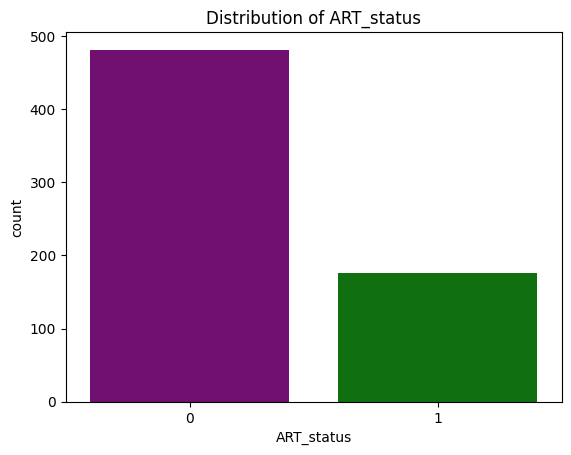

Variance Inflation Factor (VIF):
                  Feature       VIF
0             Gender_WOE  1.983256
1        New_TB_Case_WOE  1.196573
2          age_group_WOE  5.421935
3                CD4_WOE  2.405964
4  Time_To_Move_Band_WOE  2.925916
Optimization terminated successfully.
         Current function value: 0.536394
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             ART_status   No. Observations:                  657
Model:                          Logit   Df Residuals:                      651
Method:                           MLE   Df Model:                            5
Date:                Sat, 08 Nov 2025   Pseudo R-squ.:                 0.07700
Time:                        19:59:43   Log-Likelihood:                -352.41
converged:                       True   LL-Null:                       -381.81
Covariance Type:            nonrobust   LLR p-value:                 2.150e-11
                      

In [ ]:
# --- 0. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# --- 1. Load Your Data ---
# Example: df = pd.read_csv('your_data.csv')
# Ensure df exists before continuing

# --- 2. Check Class Distribution ---
print("Original Class Distribution (ART_status):\n", df['ART_status'].value_counts())

# Visualize class balance
sns.countplot(x='ART_status', data=df, palette=['purple', 'green'])
plt.title('Distribution of ART_status')
plt.show()

# --- 3. Define Features (X) and Target (y) ---

X = df.drop(columns=[
    'Age', 'Gender', 'New_TB_Case', 'Rx_Outcome_2_WOE', 'Time_To_Link_Band_WOE', 'Rx_Outcome_WOE',
    'Pulmonary_TB', 'AFB_Positive_Ever', 'Culture_Positive_Ever', 'Other_Basis_Dx_WOE',
    'Micro_Conf', 'Other_Basis_Dx', 'CD4', 'ART_status', 'COSH_PHC', 'Rx_Outcome',
    'Rx_Outcome_2', 'Culture_Positive_Ever_WOE', 'COSH_PHC_WOE', 'Time_To_Move',
    'Time_To_Link', 'age_group', 'CD4_Band', 'Time_To_Move_Band', 'Time_To_Link_Band',
    'Micro_Conf_WOE', 'Pulmonary_TB_WOE', 'AFB_Positive_Ever_WOE', 'CD4_Band_WOE'  # DROP this to avoid multicollinearity
])
y = df['ART_status']

# --- 4. Feature Scaling Safely ---

columns_to_scale = ['age_group_WOE', 'Gender_WOE', 'New_TB_Case_WOE', 'CD4_WOE', 'Time_To_Move_Band_WOE']
available_columns_to_scale = [col for col in columns_to_scale if col in X.columns]

scaler = MinMaxScaler()
X[available_columns_to_scale] = scaler.fit_transform(X[available_columns_to_scale])

# --- 5. Multicollinearity Check with VIF ---

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF):\n", vif_data)

# --- 6. Logistic Regression using statsmodels ---

X_sm = sm.add_constant(X)
model_sm = sm.Logit(y, X_sm)
result = model_sm.fit()

# --- 7. Model Summary Output ---
print(result.summary())

Training Logistic Regression...
Training Linear SVM...
Training Decision Tree...
Training Random Forest...
Training AdaBoost...
Training Extra Trees...


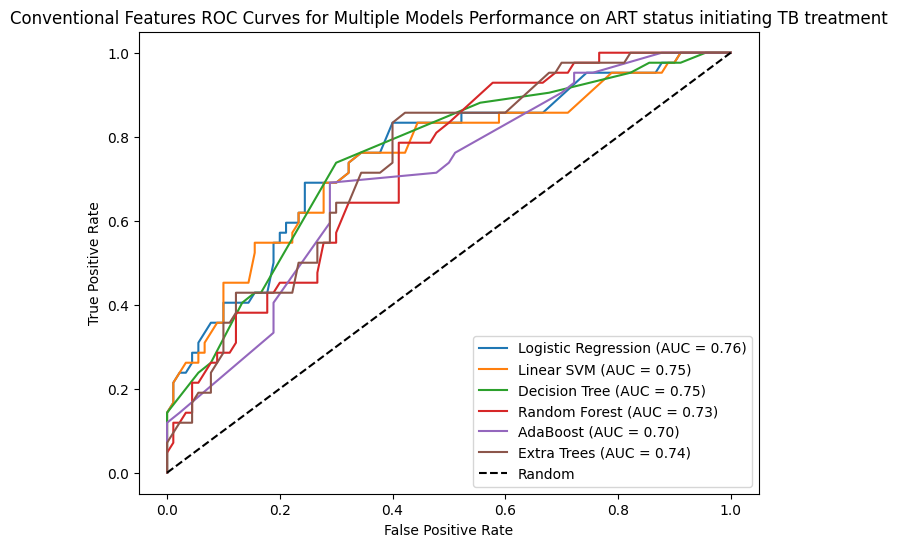

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 6. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=345)

# 7. Initialize the Logistic Regression model with class weighting
model = LogisticRegression(class_weight='balanced', penalty='l2', random_state=345)  # Using L2 regularization

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Define the models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', penalty='l2', random_state=345),
    'Linear SVM': LinearSVC(C=0.1, max_iter=2000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=345),
    'Random Forest': RandomForestClassifier(max_depth=5, min_samples_split=10, random_state=354),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.05, random_state=345),
    'Extra Trees': ExtraTreesClassifier(max_depth=5, min_samples_split=10, random_state=345),

}

# Store ROC AUC values for plotting
auc_scores = {}

# Initialize the ROC curve plot
plt.figure(figsize=(8, 6))

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Check if the model has predict_proba for ROC AUC calculation
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):  # For models like LinearSVC and SGDClassifier
        y_pred_proba = model.decision_function(X_test)
    else:
        print(f"{name} does not support probability scores, skipping ROC AUC calculation.")
        continue

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores[name] = roc_auc

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Customize the plot
plt.plot([0, 1], [0, 1], 'k--', label='Random')  # Diagonal line for a random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Conventional Features ROC Curves for Multiple Models Performance on ART status initiating TB treatment')
plt.legend(loc='lower right')
plt.show()  # Display the plot

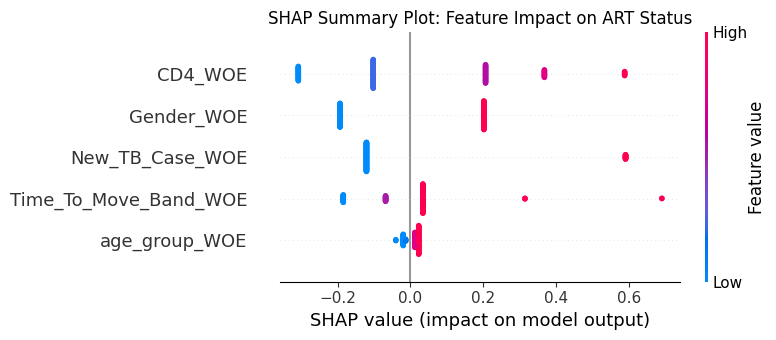

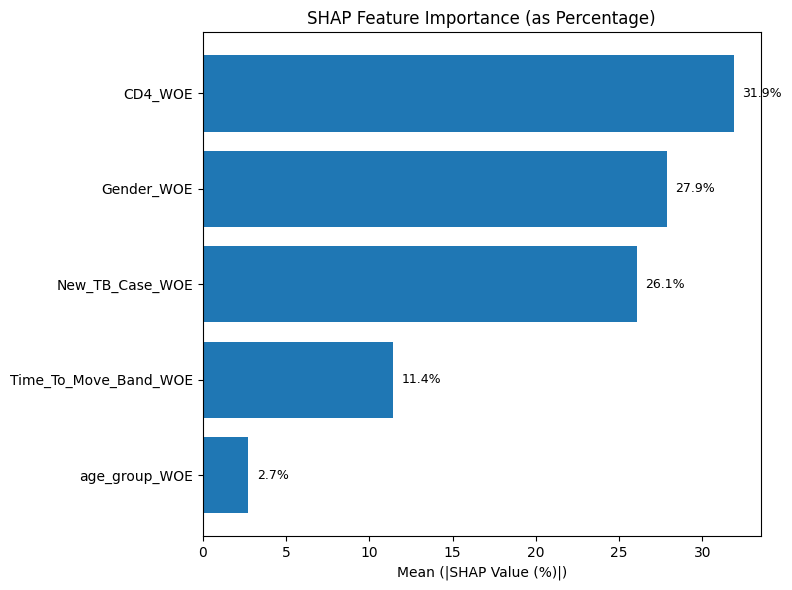

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings("ignore")

# Train the logistic regression model
model = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear', random_state=345)
model.fit(X_train, y_train)

# Use SHAP Explainer (for linear models)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot 1: Beeswarm (dot) plot
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary Plot: Feature Impact on ART Status")
plt.tight_layout()
plt.show()

# Plot 2: Bar Plot with Percentage Labels
# Step 1: Get mean absolute SHAP values
mean_shap = np.abs(shap_values.values).mean(axis=0)

# Step 2: Convert to percentage
percent_shap = 100 * mean_shap / mean_shap.sum()

# Step 3: Plot with custom labels
features = X_test.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance (%)': percent_shap
}).sort_values('Importance (%)', ascending=True)

# Step 4: Plot manually
plt.figure(figsize=(8, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance (%)'])
plt.xlabel("Mean (|SHAP Value (%)|)")
plt.title("SHAP Feature Importance (as Percentage)")

# Annotate bars with percentage values
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()
